# Mini Project — Graph Theory: Cheapest Flow (Min-Cost Max-Flow)

### Project Topic
The goal of this project is to implement and visualize the **Min-Cost Max-Flow** algorithm. This problem asks: what is the cheapest way to send the maximum possible amount of flow from a source node to a sink node?

### Theoretical Background
In a standard Max Flow problem (like Edmonds-Karp), we only care about maximizing the volume of flow. In the **Min-Cost Max-Flow** problem, every edge has two parameters:
1.  **Capacity:** The maximum amount of flow allowed.
2.  **Cost:** The cost per unit of flow traversing the edge.

The algorithm must find a flow configuration that:
1.  Maximizes the total flow from Source ($s$) to Sink ($t$).
2.  Minimizes the total cost among all maximum flow configurations.

### Algorithm Description: Successive Shortest Path
We use the **Successive Shortest Path** algorithm using **SPFA** (Shortest Path Faster Algorithm).

**How it works:**
1.  Initialize flow on all edges to 0.
2.  Construct a **residual graph**.
    * If flow flows $u \to v$ with cost $c$, the residual edge $v \to u$ has cost $-c$.
3.  Find the **shortest path** (cheapest path) from $s$ to $t$ in the residual graph based on edge costs.
    * *Note:* Since residual edges can have negative costs, we cannot use standard Dijkstra. We use **SPFA** (an improved Bellman-Ford).
4.  Push the maximum possible flow along this cheapest path.
5.  Update the residual graph and repeat until no path exists.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from collections import deque
from IPython.display import HTML
import copy

plt.rcParams["figure.figsize"] = (8, 6)

### Graph Representation
We implement a custom `MinCostGraph` class. It uses an adjacency list where every edge stores:
* Target vertex
* Capacity
* Cost (per unit)
* Current Flow
* Pointer to the reverse edge (necessary for the residual graph logic)

In [2]:
class MinCostGraph:
    def __init__(self):
        self.nodes = set()
        # Adjacency list: graph[u] = [[v, capacity, cost, flow, reverse_edge_index], ...]
        self.graph = {} 

    def add_edge(self, u, v, capacity, cost):
        if u not in self.graph: self.graph[u] = []
        if v not in self.graph: self.graph[v] = []
        self.nodes.add(u)
        self.nodes.add(v)
        
        # Forward edge: u -> v
        # Data: [target, capacity, cost, flow, index_of_reverse_edge]
        forward_idx = len(self.graph[v])
        backward_idx = len(self.graph[u])
        
        forward = [v, capacity, cost, 0, forward_idx]
        
        # Backward edge: v -> u (Residual edge)
        # Capacity is 0 initially, Cost is NEGATIVE of forward cost
        backward = [u, 0, -cost, 0, backward_idx]
        
        self.graph[u].append(forward)
        self.graph[v].append(backward)

    def get_nodes(self):
        return list(self.nodes)

### SPFA Algorithm (Shortest Path Faster Algorithm)
We need to find the cheapest path in the residual graph. Because pushing flow back creates edges with **negative costs** (reclaiming money), standard Dijkstra does not work.

We use SPFA, which is a queue-based optimization of the Bellman-Ford algorithm. It handles negative weights efficiently as long as there are no negative cycles (which don't occur in this specific problem structure).

In [3]:
def spfa(graph, source, sink, parent_map, edge_map):
    """
    Finds the shortest path (min cost) in the residual graph.
    Returns True if a path exists, False otherwise.
    Updates parent_map and edge_map to reconstruct the path.
    """
    # Initialize distances to infinity
    dist = {node: float('inf') for node in graph.get_nodes()}
    dist[source] = 0
    
    # Queue for SPFA
    in_queue = {node: False for node in graph.get_nodes()}
    queue = deque([source])
    in_queue[source] = True
    
    parent_map.clear()
    edge_map.clear()

    while queue:
        u = queue.popleft()
        in_queue[u] = False
        
        if u not in graph.graph: continue

        # Iterate over neighbors
        for i, (v, cap, cost, flow, rev_idx) in enumerate(graph.graph[u]):
            # Condition: Edge must have remaining capacity
            remaining_cap = cap - flow
            
            # Relaxation step
            if remaining_cap > 0 and dist[v] > dist[u] + cost:
                dist[v] = dist[u] + cost
                parent_map[v] = u
                edge_map[v] = i  # Store index to find the specific edge later
                
                if not in_queue[v]:
                    queue.append(v)
                    in_queue[v] = True
                    
    # Return True if we reached the sink
    return dist[sink] != float('inf')

### Main Algorithm Implementation
This function orchestrates the process:
1.  Repeatedly call `spfa` to find the cheapest augmenting path.
2.  Calculate the "bottleneck" (min capacity) on that path.
3.  Augment flow along the path (add flow to forward edges, subtract from reverse edges).
4.  Record the state for visualization.

In [4]:
def min_cost_max_flow(graph, s, t):
    """
    Executes the Min-Cost Max-Flow algorithm.
    Returns (max_flow, min_cost, history).
    """
    total_flow = 0
    min_cost = 0
    parent_map = {} 
    edge_map = {}   
    
    # History stores state after each augmentation for animation
    history = [] 
    
    # While there is a path in the residual graph
    while spfa(graph, s, t, parent_map, edge_map):
        path_flow = float('inf')
        path_nodes = []
        
        # 1. Backtrack to find the bottleneck capacity
        curr = t
        while curr != s:
            path_nodes.append(curr)
            prev = parent_map[curr]
            edge_idx = edge_map[curr]
            
            # Retrieve edge data
            v, cap, cost, flow, rev_idx = graph.graph[prev][edge_idx]
            
            path_flow = min(path_flow, cap - flow)
            curr = prev
        path_nodes.append(s)
        path_nodes.reverse()
        
        # 2. Augment flow
        total_flow += path_flow
        curr = t
        while curr != s:
            prev = parent_map[curr]
            edge_idx = edge_map[curr]
            
            # Update Forward Edge
            graph.graph[prev][edge_idx][3] += path_flow 
            cost_unit = graph.graph[prev][edge_idx][2]
            min_cost += path_flow * cost_unit
            
            # Update Backward (Residual) Edge
            rev_idx = graph.graph[prev][edge_idx][4]
            graph.graph[curr][rev_idx][3] -= path_flow 
            
            curr = prev
            
        # 3. Snapshot for animation
        current_flows = {}
        for u in graph.graph:
            for v, cap, cost, flow, _ in graph.graph[u]:
                if flow > 0:
                    current_flows[(u, v)] = (flow, cap, cost)
        
        history.append({
            'path': list(path_nodes), 
            'flows': current_flows, 
            'cost': min_cost,
            'added_flow': path_flow
        })

    return total_flow, min_cost, history

### Example Setup
We define a graph where:
* Nodes `0` is Source, `4` is Sink.
* Some paths are **cheap but narrow** (low capacity).
* Some paths are **expensive but wide** (high capacity).

The algorithm should intelligently fill the cheap paths first before resorting to the expensive ones.

In [5]:
# Create Graph Instance
g = MinCostGraph()

# Configuration: (Source, Target, Capacity, Cost)
edges_config = [
    (0, 1, 4, 1),   # Cheap, High Capacity
    (0, 2, 2, 5),   # Expensive start
    (1, 2, 2, 1),   # Connector
    (1, 3, 2, 4),   # Medium cost
    (2, 3, 1, 1),   # Cheap bottleneck
    (2, 4, 3, 5),   # Expensive finish
    (3, 4, 3, 1)    # Cheap finish
]

# Add edges to graph instance
for u, v, cap, cost in edges_config:
    g.add_edge(u, v, cap, cost)

# Run the algorithm
source, sink = 0, 4
max_f, min_c, history = min_cost_max_flow(g, source, sink)

print(f"Algorithm Finished.")
print(f"Max Flow: {max_f}")
print(f"Min Cost: {min_c}")
print(f"Augmentation Steps: {len(history)}")

Algorithm Finished.
Max Flow: 6
Min Cost: 43
Augmentation Steps: 4


### Static Visualization
Before animating, let's visualize the graph structure showing Capacity and Cost on edges.
* Label format: `Cap: X / Cost: $Y`

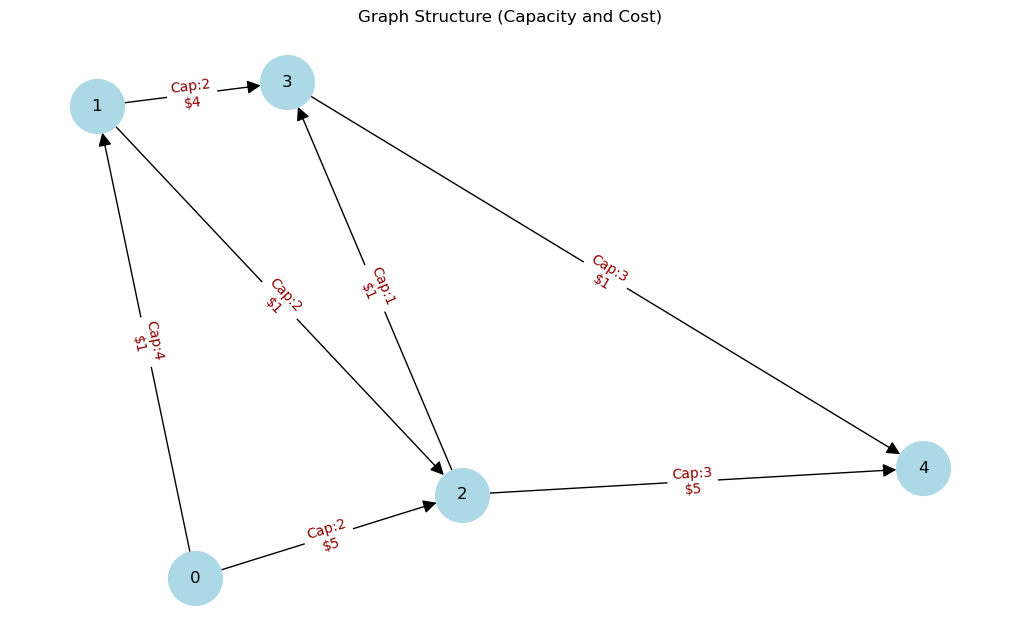

In [6]:
# NetworkX Setup for Visualization
G_vis = nx.DiGraph()
for u, v, cap, cost in edges_config:
    G_vis.add_edge(u, v, capacity=cap, weight=cost)

# Layout setup
pos = nx.spring_layout(G_vis, seed=42) 

plt.figure(figsize=(10, 6))
nx.draw(G_vis, pos, with_labels=True, node_color='lightblue', node_size=1500, arrowsize=20)

# Draw edge labels
edge_labels = {
    (u, v): f"Cap:{d['capacity']}\n${d['weight']}" 
    for u, v, d in G_vis.edges(data=True)
}
nx.draw_networkx_edge_labels(G_vis, pos, edge_labels=edge_labels, font_color='darkred')
plt.title("Graph Structure (Capacity and Cost)")
plt.show()

### Real-world Intuition & Visualization Guide

**The Logistics Company Scenario**
Before we run the simulation, let me give you a quick intuition behind it. Imagine we are running a **Logistics Company**. We need to transport goods from a **Factory (Source)** to a **Warehouse (Sink)**.

* A standard **Max-Flow** algorithm acts like a **water pipe system**—it just wants to push volume, regardless of the path.
* However, this algorithm (**Min-Cost Max-Flow**) cares about the **budget**.

Think of the edges as roads:
1.  Some are **cheap country roads** (Low Cost).
2.  Others are **expensive toll highways** (High Cost).

The algorithm is **'greedy'**. It will intelligently fill the cheap country roads **first**. It will only pay for the expensive highways when the cheap routes are completely jammed.

---

**How to read the animation:**
* <span style="color: orange; font-weight: bold">Orange Edges:</span> The cheapest path selected in the current step (SPFA result).
* <span style="color: blue; font-weight: bold">Blue Labels:</span> Format is `Current Flow / Capacity` and `(Cost)`.
* **Title:** Shows the total accumulated cost and flow added in the current step.

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

def update(step):
    ax.clear()
    
    data = history[step]
    path = data['path']
    flows = data['flows']
    current_cost = data['cost']
    
    # Draw nodes and base edges
    nx.draw(G_vis, pos, ax=ax, with_labels=True, node_color='lightblue', node_size=1500)
    
    nx.draw_networkx_edges(G_vis, pos, ax=ax, edge_color='gray', alpha=0.3, arrowsize=20)
    
    # Draw Flow Labels
    labels = {}
    for (u, v), (flow, cap, cost) in flows.items():
        labels[(u,v)] = f"{flow}/{cap} (${cost})"
    
    nx.draw_networkx_edge_labels(G_vis, pos, edge_labels=labels, ax=ax, font_color='blue')

    # Highlight the current augmenting path
    if path:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(G_vis, pos, edgelist=path_edges, edge_color='orange', width=2, alpha=0.6, ax=ax)
        
    ax.set_title(f"Step {step+1}: Added Flow {data['added_flow']} | Total Cost: {current_cost}")

if len(history) > 0:
    ani = FuncAnimation(fig, update, frames=len(history), interval=2000, repeat=False)
    plt.close(fig)
    display(HTML(ani.to_jshtml()))
else:
    print("No flow found.")

### Conclusion and Complexity Analysis

**Time Complexity:**
The complexity depends on the flow amount ($f^*$) and the Shortest Path algorithm used.
* Since we use SPFA, the worst-case complexity is technically $O(f^* \cdot V \cdot E)$, though in practice SPFA is much faster, often close to $O(f^* \cdot E)$.
* Because we augment flow unit by unit (or by bottleneck capacity), the number of iterations is bounded by the max flow value.

**Interpretation:**
The animation clearly demonstrates the "Greedy" nature of the algorithm. It always saturates the cheapest routes available (Graph Theory equivalent of "Low Hanging Fruit") before it is forced to use more expensive edges to achieve higher flow.

**Applications:**
* Mentioned Supply Chain Management (Transporting goods with minimal fuel cost).
* Data Network Routing (Routing packets with minimal latency/cost).